# Image Classifier

Implementation of an image classifier model, based in [PyTorch's MNIST example](https://github.com/pytorch/examples/blob/master/mnist/main.py).

## Training

First we will train a machine learning model, which will help us classify news across multiple categories.
This model will use a custom reusable server, responsible for loading a PyTorch model.

### Install dependencies 

We will need the following dependencies in order to run the Python code:

In [2]:
%%writefile src/requirements.txt
torch==1.3.1
torchvision==0.4.2
matplotlib==3.1.2

Overwriting src/requirements.txt


We can now install the dependencies using the make command:

In [9]:
%%bash
make install_dev

pip install -r src/requirements.txt


### Download the ML data

Now that we have all the dependencies we can proceed to download the data.

We will download the news stories dataset, and we'll be attempting to classify across the four classes below.

In [10]:
from src.data import fetch_test, fetch_training

training_dataset = fetch_training()
test_dataset = fetch_test()

We can have a look into the data to see a few examples:

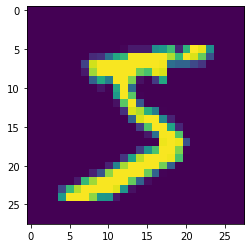

In [11]:
import matplotlib.pyplot as plt

x_example, y_example = training_dataset[0]
plt.imshow(x_example.squeeze())

### Train a model

Now that we've downloaded the data, we can train the ML model using a simple pipeline with basic text pre-processors and a Multiclass naive bayes classifier

In [12]:
import torch
import torch.optim as optim
from src.data import fetch_test, fetch_training
from src.model import Classifier
from src.train import test_epoch, train_epoch
from torch.optim.lr_scheduler import StepLR

batch_size = 256
epochs = 2
lr = 1.0
gamma = 0.7

train_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

model = Classifier()
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train_epoch(model, train_loader, optimizer, epoch)
    test_epoch(model, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308114
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.369711
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.638653
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.428343
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.357857
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.446279
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.319209
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.221589
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.280998
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.170742
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.218999
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.206189
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.111903
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.242586
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.206079
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.210710
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.171747
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.247889
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.060543
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.144133
Train Epoc

### Test single prediction

Now that we've trained our model we can use it to predict from un-seen data.

We can see below that the model is able to predict the first datapoint in the dataset correctly.

In [13]:
y_pred = model(x_example.unsqueeze(0))
print(f"PREDICTED: {y_pred.argmax()}")
print(f"ACTUAL: {y_example}")

PREDICTED: 5
ACTUAL: 5


### Print accuracy

We can print the accuracy of the model by running the test data and counting the number of correct classes.

In [14]:
test_epoch(model, test_loader)


Test set: Average loss: 0.0470, Accuracy: 9846/10000 (98%)



## Deployment

Now we want to be able to deploy the model we just trained. This will just be as simple as updated the model binary.

### Save the trained model

First we have to save the trained model in the `src/` folder.
This is the artifact we will upload to our model registry and which the wrapper will load.

In [15]:
import os

model_path = os.path.join("src", "model.pt")
torch.save(model.state_dict(), model_path)

### Update your unit test

We'll write a very simple unit test that make sure that the model loads and runs as expected.

In [19]:
%%writefile ./src/test_model.py
from src.model import Classifier

def test_model():
    data = ["text 1", "text 2"]

    model = Classifier()
    model_path = "model.pt"
    model_state_dict = torch.load(model_path)
    model.load_state_dict(model_state_dict)
    y_pred = model(x_example.unsqueeze(0))

    assert all(y_pred == 5)

Writing ./src/test_model.py


In [25]:
restored_model.forward()

<bound method Classifier.forward of Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)>

In [20]:
%%bash
make test

cd src && \
	pytest -s --verbose -W ignore --log-level=INFO 2>&1
============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-5.1.1, py-1.8.0, pluggy-0.13.1 -- /home/agm/.virtualenvs/sig-mlops/bin/python3.6
cachedir: .pytest_cache
rootdir: /home/agm/Seldon/sig-mlops-jenkins-classic/models/image_classifier/src
collecting ... collected 1 item

test_model.py::test_model FAILED

=================================== FAILURES ===================================
__________________________________ test_model __________________________________

    def test_model():
        data = ["text 1", "text 2"]
    
        model = Classifier()
>       model.load_state_dict("model.pt")

test_model.py:7: 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

self = Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), ...): Linear(in_features=9216, out_featu

make: *** [Makefile:10: test] Error 1


CalledProcessError: Command 'b'make test\n'' returned non-zero exit status 2.

### Updating Integration Tests

We can also now update the integration tests. This is another very simple step, where we'll want to test this model specifically.


In [12]:
!pygmentize integration/test_e2e_seldon_model_server.py

from seldon_core.seldon_client import SeldonClient
from seldon_core.utils import seldon_message_to_json
import numpy as np
from subprocess import run
import time
import logging


API_AMBASSADOR = "localhost:8003"

def test_sklearn_server():
    data = ["From: brian@ucsd.edu (Brian Kantor)\nSubject: Re: HELP for Kidney Stones ..............\nOrganization: The Avant-Garde of the Now, Ltd.\nLines: 12\nNNTP-Posting-Host: ucsd.edu\n\nAs I recall from my bout with kidney stones, there isn't any\nmedication that can do anything about them except relieve the pain.\n\nEither they pass, or they have to be broken up with sound, or they have\nto be extracted surgically.\n\nWhen I was in, the X-ray tech happened to mention that she'd had kidney\nstones and children, and the childbirth hurt less.\n\nDemerol worked, although I nearly got arrested on my way home when I barfed\nall over the police car parked just outside the ER.\n\t- Brian\n",
            'From: rind@enterprise.bih.harvard.edu (David R

### Now push your changes to trigger the pipeline
Because Jenkins Classic has created a CI GitOps pipeline for our repo we just need to push our changes to run all the tests

We can do this by running our good old git commands:

In [ ]:
%%bash
git add .
git push origin master

We can now see that the pipeline has been triggered by viewing our activities:


In [16]:
!jx get activity -f sig-mlops-seldon-jenkins-x | tail

    Create Effective Pipeline                          11h28m57s       7s Succeeded 
    Create Tekton Crds                                 11h28m50s      11s Succeeded 
  test and deploy sklearn server                       11h28m38s    1m54s Succeeded 
    Credential Initializer 59hx6                       11h28m38s       0s Succeeded 
    Working Dir Initializer Fslpm                      11h28m38s       1s Succeeded 
    Place Tools                                        11h28m37s       1s Succeeded 
    Git Source Seldonio Sig Mlops Seldon Jenki Ftjtn   11h28m36s       6s Succeeded https://github.com/SeldonIO/sig-mlops-seldon-jenkins-x.git
    Git Merge                                          11h28m30s       1s Succeeded 
    Run Tests                                          11h28m29s      13s Succeeded 
    Build And Push Images                              11h28m16s    1m32s Succeeded 


Similarly we can actually see the logs of our running job:

In [22]:
%%bash
YOUR_GIT_USERNAME=SeldonIO
jx get build logs "$YOUR_GIT_USERNAME/sig-mlops-seldon-jenkins-x/master #7 release" | tail

error: Failed to parse docker reference ELDON_BASE_WRAPPER
ERROR: An error occurred: unable to get metadata for ELDON_BASE_WRAPPER:latest
ERROR: Suggested solution: check image name
ERROR: If the problem persists consult the docs at https://github.com/openshift/source-to-image/tree/master/docs. Eventually reach us on freenode #openshift or file an issue at https://github.com/openshift/source-to-image/issues providing us with a log from your build using log output level 3.
Makefile:8: recipe for target 'build' failed
make: *** [build] Error 1
Stopping Docker: dockerProgram process in pidfile '/var/run/docker-ssd.pid', 1 process(es), refused to die.

Pipeline failed on stage 'test-and-deploy-sklearn-server' : container 'step-build-and-push-images'. The execution of the pipeline has stopped.



wrote: /tmp/086bfe4e-d4ac-46e6-baa1-71d4ef7abca4095596018


## Managing your Jenkins X Application

Now that we've deployed our MLOps repo, Jenkins X now has created an application from our charts.

This application gets automatically syncd into the Jenkins X staging environment, which you can see:

In [ ]:
!kubectl get pods -n jx-staging

### Test your application in the staging environment

In [163]:
from seldon_core.seldon_client import SeldonClient
import numpy as np

url = !kubectl get svc ambassador -o jsonpath='{.status.loadBalancer.ingress[0].hostname}'

sc = SeldonClient(
    gateway="ambassador", 
    gateway_endpoint="localhost:80",
    deployment_name="mlops-server",
    payload_type="ndarray",
    namespace="jx-staging",
    transport="rest")

response = sc.predict(data=np.array([twenty_test.data[0]]))

response.response.data

ndarray {
  values {
    number_value: 2.0
  }
}

In [165]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
     -d "{'data': {'names': ['text'], 'ndarray': ['Hello world this is a test']}}" \
    http://localhost/seldon/jx-staging/news-classifier-server/api/v0.1/predictions

{
  "meta": {
    "puid": "so6n21pkf70fm66eka28lc63cr",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "news-classifier-server-processor": "axsauze/sklearn-server:0.1"
    },
    "metrics": []
  },
  "data": {
    "names": [],
    "ndarray": [2.0]
  }
}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   350  100   278  100    72   7942   2057 --:--:-- --:--:-- --:--:-- 10294
